## ARTIFICIAL CARS

In [ ]:
import os

from torchvision import transforms
from torchvision import utils
import torch as th

import matplotlib.pyplot as plt
from scripts import *

potsdam_dir = "/home/hca/Documents/Master/Thesis/potsdam_data/cem-v0/v2/training_tightcanvas_graybackground"

transform = transforms.Compose([#transforms.ColorJitter(hue=[-0.1, 0.1]),
                                DynamicPad(min_img_dim=(120, 60),
                                           padding_mode="constant", padding_value=125),
                                transforms.Resize((60, 120)),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomVerticalFlip(p=0.5),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])])
datasetmodule = PostdamCarsDataModule(potsdam_dir, batch_size=64, transform=transform)
datasetmodule.setup()
dataloader = datasetmodule.train_dataloader()

real, _ = next(iter(dataloader))
grid = utils.make_grid(real, normalize=True, normalize_range=(-1, 1), pad_value=1)
utils.save_image(grid, "figs/artificial_cars_munit_gray.png")

## POTSDAM VISUALIZATION

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

training_img  = "/home/hca/Documents/Master/Thesis/potsdam_data/training/top_potsdam_7_7_RGB.tif"
training_mask =  "/home/hca/Documents/Master/Thesis/potsdam_data/training/top_potsdam_7_7_label.tif"

test_img  = "/home/hca/Documents/Master/Thesis/potsdam_data/test/top_potsdam_4_13_RGB.tif"
test_mask = "/home/hca/Documents/Master/Thesis/potsdam_data/test/top_potsdam_4_13_label.tif"


train = cv2.imread(training_img)
mask = cv2.imread(training_mask)

w, h = 3000, 3000
w1, h1 = 100, 200

small_train = train[w:w+2000, h:h+2000]
small_mask = mask[w:w+2000, h:h+2000]
small_train = cv2.cvtColor(small_train, cv2.COLOR_BGR2RGB)
small_mask = cv2.cvtColor(small_mask, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(small_train)
plt.gca().add_patch(Rectangle((h1,w1),400,400,linewidth=5,edgecolor="k",facecolor='none'))
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(small_mask)
plt.gca().add_patch(Rectangle((h1,w1),400,400,linewidth=5,edgecolor='k',facecolor='none'))
plt.axis("off")
plt.tight_layout()
plt.savefig("figs/small_train.png", dpi=300)

small_train_ = small_train[w1:w1+400, h1:h1+400]
small_mask_ = small_mask[w1:w1+400, h1:h1+400]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(small_train_)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(small_mask_)
plt.axis("off")
plt.tight_layout()
plt.savefig("figs/small_train_zoom.png", dpi=300)

## BORDER ARTIFACTS

In [ ]:
import os
import argparse

import torch as th
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches

from scripts.callbacks import *
from scripts.models import *
from scripts.dataloader import *


@ th.no_grad()
def plot_generator_steps(z, pl_module):
    pl_module.eval()

    # Generator Inner Layers
    init_channels = pl_module.generator.init_channels
    init_height = pl_module.generator.init_height
    init_width = pl_module.generator.init_width
    x = pl_module.generator.l1(z).reshape(
        1, init_channels, init_height, init_width).detach()
    gen_inter_layers = []
    layer_i = 0
    for layer in pl_module.generator.conv_blocks[:-1]:
        x = layer(x)
        if layer.__class__.__name__ in ["ConvBlock", "BatchNorm2d", "ResBlock"]:
            gen_inter_layers.append(x)
    x = pl_module.generator.conv_blocks[-1](x)
    return x, gen_inter_layers[-1]


checkpoint_path = "experiments/dcgan_experiments/lightning_logs/version_0/checkpoints/epoch=449.ckpt"

# load model
model = GAN.load_from_checkpoint(checkpoint_path)
model.eval()

with th.no_grad():
    z = th.normal(0, 1, (1, model.generator.latent_dim),
                  device=model.device)
    fake_image, last_activation = plot_generator_steps(z, model)

    x = fake_image.detach().clone()
    for i, layer in enumerate(model.discriminator.conv_blocks):
        x = layer(x)
        if layer.__class__.__name__ in ["ConvBlock", "AvgPool2d"]:
            break
    first_activation = x.detach().clone()
    
first_activation_grid =  torchvision.utils.make_grid(first_activation.permute(1, 0, 2, 3), 
                                                     nrow=8, padding=1, 
                                                     normalize=True, pad_value=1).numpy().transpose((1, 2, 0))   
# make numpy
fake_image = (th.squeeze(fake_image.detach().clone().cpu().permute(0, 2, 3, 1)).numpy() + 1) / 2
last_activation = last_activation.detach().clone().cpu().permute(1, 2, 3, 0).numpy() 
last_activation /= np.max(last_activation, axis=(1,2,3)).reshape(len(last_activation), 1, 1, 1)
first_activation = first_activation.detach().clone().cpu().permute(1, 2, 3, 0).numpy()
first_activation /= np.max(first_activation, axis=(1,2,3)).reshape(len(first_activation), 1, 1, 1)

plt.figure(figsize=(18, 9))
rec1 = patches.Rectangle((6*32 + 5*1 + 1, 0), 32.5, 16.5,linewidth=3,edgecolor='r',facecolor='none', linestyle="-",)
rec2 = patches.Rectangle((0, 2*16 + 2), 32.5, 16.5,linewidth=3,edgecolor='b',facecolor='none', linestyle="-",)
plt.gca().add_patch(rec1)
plt.gca().add_patch(rec2)
plt.imshow(first_activation_grid)
plt.axis(False)
plt.tight_layout()
plt.savefig("figs/first_activation.png", dpi=300)

plt.figure(figsize=(18, 9))
plt.imshow(fake_image)
plt.axis(False)
plt.tight_layout()
plt.savefig("figs/fake_image.png", dpi=300)

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
rec1 = patches.Rectangle((-0.5,-0.5), 32, 16,linewidth=10,edgecolor='r',facecolor='none', linestyle="-",)
plt.gca().add_patch(rec1)
plt.imshow(first_activation[6], cmap="gray")
plt.axis(False)
plt.subplot(1, 2, 2)
rec1 = patches.Rectangle((-0.5,-0.5), 32, 16,linewidth=10,edgecolor='b',facecolor='none', linestyle="-",)
plt.gca().add_patch(rec1)
plt.imshow(first_activation[16], cmap="gray")
plt.axis(False)
plt.tight_layout()
plt.savefig("figs/zoomed_activations.png", dpi=300)


## FID CURVES

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib

# save plots for latex
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

fid_0 = "experiments/dcgan_experiments/version_0/results/fid_scores.npy"
fid_1 = "experiments/dcgan_experiments/version_1/results/fid_scores.npy"
fid_2 = "experiments/dcgan_experiments/version_2/results/fid_scores.npy"

# load the data
fid_0_ = np.load(fid_0, allow_pickle=True).item()["fid_train"]
fid_1_ = np.load(fid_1, allow_pickle=True).item()["fid_train"]
fid_2_ = np.load(fid_2, allow_pickle=True).item()["fid_train"]
epochs = [i-1 for i in range(25, 1000, 25)] + [1000-1]
plot_idx = [i for i in range(0, len(fid_2_), 5)] + [len(fid_2_)-1]

plt.figure(figsize=(10, 6))
plt.xticks(plot_idx, [epochs[i] for i in plot_idx], fontsize=20)
plt.yticks([i for i in range(0, 10)], [i for i in range(0, 10)], fontsize=20)
plt.ylim([0, 10])
plt.xlim([-0.5, 40.5])
plt.ylabel("FID Score", fontsize=22)
plt.xlabel("Epochs", fontsize=22)
plt.plot(fid_0_, "--", marker="^", linewidth=3, label="A Baseline")
plt.plot(fid_1_, "--", marker="*", linewidth=3, label="B + Padding Reflect")
plt.plot(fid_2_, "--", marker="o", linewidth=3, label="C + LR Scheduler")
plt.plot( [-10, len(fid_2_)+10], [1.33, 1.33], "--k", linewidth=3, label="Training Data")
plt.legend(prop={'size': 16})
plt.grid(True)
plt.tight_layout()
plt.savefig("figs/fid_curves.png", dpi=300)
plt.savefig("figs/fid_curves.pgf", dpi=300)


## VISUAL COMPARISION

In [ ]:
import os
import argparse

import torch as th
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches

from scripts.callbacks import *
from scripts.models import *
from scripts.dataloader import *

model1 = GAN.load_from_checkpoint("experiments/dcgan_experiments/lightning_logs/version_0/checkpoints/epoch=449.ckpt")
model1.eval()
model2 = GAN.load_from_checkpoint("experiments/dcgan_experiments/lightning_logs/version_1/checkpoints/epoch=524.ckpt")
model2.eval()
model3 = GAN.load_from_checkpoint("experiments/dcgan_experiments/lightning_logs/version_2/checkpoints/epoch=974.ckpt")
model3.eval()
model4 = GAN.load_from_checkpoint("experiments/dcgan_experiments_500/lightning_logs/version_0/checkpoints/epoch=1294.ckpt")
model4.eval()


with th.no_grad():
    gen_in = th.normal(0, 1, size=(30, 100))
    fake = model1(gen_in)
    grid =  torchvision.utils.make_grid(fake, nrow=10, padding=1, normalize=True, pad_value=1)
    torchvision.utils.save_image(grid, "figs/modelA_images.png")
    
    gen_in = th.normal(0, 1, size=(30, 100))
    fake = model2(gen_in)
    grid =  torchvision.utils.make_grid(fake, nrow=10, padding=1, normalize=True, pad_value=1)
    torchvision.utils.save_image(grid, "figs/modelB_images.png")
    
    gen_in = th.normal(0, 1, size=(30, 100))
    fake = model3(gen_in)
    grid =  torchvision.utils.make_grid(fake, nrow=10, padding=1, normalize=True, pad_value=1)
    torchvision.utils.save_image(grid, "figs/modelC_images.png")
    
    gen_in = th.normal(0, 1, size=(30, 100))
    fake = model4(gen_in)
    grid =  torchvision.utils.make_grid(fake, nrow=10, padding=1, normalize=True, pad_value=1)
    torchvision.utils.save_image(grid, "figs/modelD_images.png")

## CLOSTEST MATCH ON REAL DATASET

In [ ]:
import os
import argparse

import torch as th
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches

from scripts.callbacks import *
from scripts.models import *
from scripts.dataloader import *


with th.no_grad():
    model = GAN.load_from_checkpoint("experiments/dcgan_experiments/lightning_logs/version_2/checkpoints/epoch=974.ckpt")
    model.eval()
    model.cuda()
    gen_in = th.normal(0, 1, size=(20, 100))
    fake = model(gen_in.cuda()).detach().cpu().clone()
    act2 = np.squeeze(vgg16_get_activation_maps(
        fake, layer_idx=33, device="cuda:0", normalize_range=(-1, 1)).numpy())


    potsdam_dir = "../potsdam_data/potsdam_cars_corrected"
    dataset = PostdamCarsDataModule(potsdam_dir, batch_size=4300)
    dataset.setup()
    potsdam_cars_dataloader = dataset.train_dataloader()

    real,_ = next(iter(potsdam_cars_dataloader))
    act1 = np.squeeze(vgg16_get_activation_maps(
        real, layer_idx=33, device="cuda:0", normalize_range=(-1, 1)).cpu().numpy())


    act1_norm = np.expand_dims(np.linalg.norm(act1, axis=1), 1)
    act2_norm = np.expand_dims(np.linalg.norm(act2, axis=1), 1)
    norms_inverse = 1 / (act2_norm.dot(act1_norm.T))

    norms_inverse[np.isinf(norms_inverse)] = 0

    # cos distance between two activations
    cos_distances = (1 - norms_inverse*act2.dot(act1.T))
    cos_distance = cos_distances.min(axis=1)  # min for each row

    jj = np.argsort(cos_distance) # best
    n = 10
    imgs = []
    for j in jj:
        idx = np.argsort(cos_distances[j])

        imgs.append(fake[j])
        for idx_ in idx[:n]:
            imgs.append(real[idx_])
            
    grid = torchvision.utils.make_grid(imgs, nrow=n+1, padding=1, normalize=True, pad_value=1)
    torchvision.utils.save_image(grid, "figs/modelC_best.png")

## PCA DISTRIBUTION

In [1]:
import os
import pickle

import torch as th 
import numpy as np
import matplotlib.pyplot as plt
import torchvision;

from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

from scripts import *

import matplotlib

# save plots for latex
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

save_path = "experiments/ganspace/dcgan_experiments_version_2_epoch=974"
layer="linear"
n_time=5
pca_path = os.path.join(save_path, layer, "pca.pkl")

f = open(pca_path, 'rb')
pca = pickle.load(f)
f.close()

# load dataset
X = np.concatenate([np.load(os.path.join(save_path, layer, f"X{i+1}.npy")) for i in range(n_time)], axis=0)
y = np.concatenate([np.load(os.path.join(save_path, layer, f"y{i+1}.npy")) for i in range(n_time)], axis=0)

# information gain
information_gain = np.cumsum(pca.explained_variance_ratio_)
idx = np.where(information_gain >= 0.9)[0][0]
idx = 12

# 
comp = pca.components_[:idx]
mean = pca.mean_

# reconstruction
X_pca = (X - mean).dot(comp.T) 

# resonctruction error
X_rec = X_pca.dot(comp) + mean
np.linalg.norm(X_rec - X) / len(X)

columns = 4
rows = 1
fig=plt.figure(figsize=(columns*5, rows*5))
from scipy.stats import norm


for i in range(1, columns*rows +1):
    dim = X_pca[:, i-1]
    fig.add_subplot(rows, columns, i)
    
    # data dist
    plt.hist(dim, bins=50, density=True, alpha=0.6)
    
    # fit gaus
    mu, std = dim.mean(), dim.std()
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k--', linewidth=2)
    
    plt.title("Principle Dimension %d" % i, fontsize=30)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.savefig("figs/eigen_dim_distributions.png", dpi=300)
plt.savefig("figs/eigen_dim_distributions.pgf", dpi=300)

## PCA VARIANCE PERCENTAGE

In [ ]:
import os
import pickle

import torch as th 
import numpy as np
import matplotlib.pyplot as plt
import torchvision;

from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

from scripts import *

import matplotlib

# save plots for latex
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

MAX = 50

# Experiement C
save_path = "experiments/ganspace/dcgan_experiments_version_2_epoch=974"
layer="linear"
n_time=5
pca_path = os.path.join(save_path, layer, "pca.pkl")

f = open(pca_path, 'rb')
pca = pickle.load(f)
f.close()

idx=30
MAX=idx
color=["blue" if i < idx else "red" for i in range(MAX)]

plt.figure(figsize=(8, 4))
plt.bar(np.arange(2, 2*MAX+2, 2), 
        100*pca.explained_variance_ratio_[:MAX], 
        width=1.4, color=color, alpha=0.75)
#plt.xticks(np.arange(2, 2*MAX+2, 2), 1 + np.arange(MAX), fontsize=16, rotation=90)
plt.xticks([2, 2*idx, 2*MAX], [1, idx, MAX], fontsize=16, rotation=90)
plt.yticks(fontsize=16)
plt.ylim([0, 18])
plt.ylabel("Variance Percentage (%)", fontsize=18)
plt.xlabel("Principal Components", fontsize=18)
plt.grid(axis='y')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig("figs/pca_variance_percentage_C.png", dpi=300)
plt.savefig("figs/pca_variance_percentage_C.pgf", dpi=300)
plt.clf()
plt.close()

# Experiment D
save_path = "experiments/ganspace/dcgan_experiments_500_version_0_epoch=1294"
layer="linear"
n_time=5
pca_path = os.path.join(save_path, layer, "pca.pkl")

f = open(pca_path, 'rb')
pca = pickle.load(f)
f.close()

idx=12
MAX=idx
color=["blue" if i < idx else "red" for i in range(MAX)]

plt.figure(figsize=(8, 4))
plt.bar(np.arange(2, 2*MAX+2, 2), 
        100*pca.explained_variance_ratio_[:MAX], 
        width=1.4, color=color, alpha=0.75)
#plt.xticks(np.arange(2, 2*MAX+2, 2), 1 + np.arange(MAX), fontsize=16, rotation=90)
plt.xticks([2, 2*idx, 2*MAX], [1, idx, MAX], fontsize=16, rotation=90)
plt.yticks(fontsize=16)
plt.ylabel("Variance Percentage (%)", fontsize=18)
plt.xlabel("Principal Components", fontsize=18)
plt.grid(axis='y')
plt.ylim([0, 18])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig("figs/pca_variance_percentage_D.png", dpi=300)
plt.savefig("figs/pca_variance_percentage_D.pgf", dpi=300)
plt.clf()
plt.close()

## DATA SIZE DISTRIBUTION

In [64]:
import os
import pickle

from scipy.stats import norm
import cv2
import numpy as np
import matplotlib.pyplot as plt

import matplotlib

# save plots for latex
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

potsdam_dataset = "../potsdam_data/potsdam_cars_corrected"

munit_cropped_images = "experiments/munit_version_2_larger_image_corrected/version_0/10000_cars_cropped"

def get_w_h(folder):
    w, h = [], []
    for f in os.listdir(folder):
        f = os.path.join(folder, f)
        img = cv2.imread(f)
        if img is not None:
            ww, hh, _ = img.shape
            w.append(ww)
            h.append(hh)
    return w, h


p_w, p_h = get_w_h(potsdam_dataset)
m_w, m_h = get_w_h(munit_cropped_images)

plt.figure()
plt.bar([32], [1], width=2, color="green", alpha=0.75)
plt.hist(m_w, bins=20, density=True, alpha=0.75)
plt.hist(p_w, bins=50, density=True, alpha=0.75)
plt.ylim([0, 0.2])

plt.xlim([0, 80])

xmin, xmax = plt.xlim()
x = np.linspace(30, 60)
mu, std = np.mean(p_w), np.std(p_w)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k--', linewidth=2)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.yticks([])
plt.xticks(fontsize=22)
plt.xlabel("Car Width (in pixels)", fontsize=24)
plt.tight_layout()
plt.savefig("figs/width_distribuion.png", dpi=300)
plt.savefig("figs/width_distribuion.pgf", dpi=300)
plt.clf()
plt.close()

plt.show()
plt.figure()
plt.bar([64], [1], width=5, color="green", alpha=0.75)
plt.hist(m_h, bins=20, density=True, alpha=0.75)
plt.hist(p_h, bins=50, density=True, alpha=0.75)
plt.xlim([0, 200])
plt.ylim([0, 0.07])
xmin, xmax = plt.xlim()
x = np.linspace(50, 150)
mu, std = np.mean(p_h), np.std(p_h)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k--', linewidth=2)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.yticks([])
plt.xticks(fontsize=22)
plt.xlabel("Car Length (in pixels)", fontsize=24)
plt.tight_layout()
plt.savefig("figs/height_distribution.png", dpi=300)
plt.savefig("figs/height_distribution.pgf", dpi=300)
plt.clf()
plt.close()

## Style Mixing

In [30]:
import os

from torchvision import transforms
from torchvision import utils
import torch as th

import matplotlib.pyplot as plt
from scripts import *

potsdam_dir = "../potsdam_data/potsdam_cars_corrected"
artificial_dir = "../potsdam_data/cem-v0/v2/training_tightcanvas_graybackground"
img_dim = (3, 40, 80)

# DATA AUG FOR
transform1 = transforms.Compose([transforms.ColorJitter(hue=[-0.1, 0.1]),
                                 DynamicPad(min_img_dim=(110, 60),
                                            padding_mode="edge"),
                                 transforms.RandomCrop(
                                     (55, 105), padding_mode="reflect"),
                                 transforms.Resize(img_dim[1:]),
                                 transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomVerticalFlip(p=0.5),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.5], [0.5])])

transform2 = transforms.Compose([transforms.ColorJitter(hue=[-0.1, 0.1]),
                                 DynamicPad(min_img_dim=(130, 70),
                                            padding_mode="constant", padding_value=125),
                                 transforms.RandomRotation(
                                     degrees=5, resample=PIL.Image.NEAREST, fill=125),
                                 transforms.RandomCrop(
                                     (60, 120), padding_mode="reflect"),
                                 transforms.Resize(img_dim[1:]),
                                 transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomVerticalFlip(p=0.5),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.5], [0.5]),
                                 AddNoise(alpha=0.07)])


potsdam = PostdamCarsDataModule(
    potsdam_dir, img_size=img_dim[1:], batch_size=5,
    data_dir2=artificial_dir, transform=transform1, transform2=transform2)
potsdam.setup()
dataloader = potsdam.train_dataloader()

# style and content vector
real, artificial = next(iter(dataloader))


# munit1
path = "experiments/munit_version_2_larger_image_corrected/lightning_logs/version_1/checkpoints/epoch=899.ckpt"
model = MUNIT.load_from_checkpoint(path)
model.eval()
model.cuda()

encoder1 = model.generator.encoder1
encoder2 = model.generator.encoder2
decoder1 = model.generator.decoder1
decoder2 = model.generator.decoder2
img_styles = real.to(model.device)
img_contents = artificial.to(model.device)

contents, _ = encoder1(img_contents)
_, styles = encoder2(img_styles)

# image styles will be the first row
grid = [th.ones(real.shape[1:], device="cpu")] + \
    [img_style.detach().cpu().clone()
     for img_style in img_styles]

for i, content in enumerate(contents):
    # for each content create n_random_styles
    row = th.cat(
        [th.unsqueeze(content, 0) for _ in range(len(img_styles))], dim=0)
    imgs = decoder2(row.to(model.device),
                    styles.to(model.device))

    # a row consists of content image and its style mixing
    grid.append(img_contents[i].detach().cpu().clone())
    grid += [img.detach().cpu().clone()
             for img in imgs]

# save everyting
grid = torchvision.utils.make_grid(
    grid, nrow=len(img_styles) + 1, pad_value=1, padding=7, normalize=True, range=(-1, 1))
torchvision.utils.save_image(grid, "figs/style_mixing_munit1.png")



# munit2
path = "experiments/munit_version_2_larger_image_corrected_500/lightning_logs/version_0/checkpoints/epoch=499.ckpt"
model = MUNIT.load_from_checkpoint(path)
model.eval()
model.cuda()

encoder1 = model.generator.encoder1
encoder2 = model.generator.encoder2
decoder1 = model.generator.decoder1
decoder2 = model.generator.decoder2
img_styles = real.to(model.device)
img_contents = artificial.to(model.device)

contents, _ = encoder1(img_contents)
_, styles = encoder2(img_styles)

# image styles will be the first row
grid = [th.ones(real.shape[1:], device="cpu")] + \
    [img_style.detach().cpu().clone()
     for img_style in img_styles]

for i, content in enumerate(contents):
    # for each content create n_random_styles
    row = th.cat(
        [th.unsqueeze(content, 0) for _ in range(len(img_styles))], dim=0)
    imgs = decoder2(row.to(model.device),
                    styles.to(model.device))

    # a row consists of content image and its style mixing
    grid.append(img_contents[i].detach().cpu().clone())
    grid += [img.detach().cpu().clone()
             for img in imgs]

# save everyting
grid = torchvision.utils.make_grid(
    grid, nrow=len(img_styles) + 1, pad_value=1, padding=7, normalize=True, range=(-1, 1))
torchvision.utils.save_image(grid, "figs/style_mixing_munit2.png")

## TESTING MUNIT

In [46]:
import os

from torchvision import transforms
from torchvision import utils
import torch as th

import matplotlib.pyplot as plt
from scripts import *

artificial_dir = "../potsdam_data/cem-v0/v2/test_one_sample"
img_dim = (3, 40, 80)

transform1 = transforms.Compose([DynamicPad(min_img_dim=(110, 60),
                                            padding_mode="constant", padding_value=125),
                                 transforms.RandomRotation(
                                     degrees=5, resample=PIL.Image.NEAREST, fill=125),
                                 transforms.Resize(img_dim[1:]),
                                 transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomVerticalFlip(p=0.5),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.5], [0.5]),
                                 AddNoise(alpha=0.07)])


potsdam = PostdamCarsDataModule(
    artificial_dir, img_size=img_dim[1:], batch_size=10, transform=transform1)
potsdam.setup()
dataloader = potsdam.train_dataloader()

# style and content vector
artificial, _ = next(iter(dataloader))

random_styles = th.normal(0, 1, size=(10, 8), device=model.device)

# munit1
path = "experiments/munit_version_2_larger_image_corrected/lightning_logs/version_1/checkpoints/epoch=899.ckpt"
model = MUNIT.load_from_checkpoint(path)
model.eval()
model.cuda()

encoder1 = model.generator.encoder1
encoder2 = model.generator.encoder2
decoder1 = model.generator.decoder1
decoder2 = model.generator.decoder2

img_contents = artificial.to(model.device)
real_contents, _ = encoder1(img_contents)


grid = []
for i, content in enumerate(real_contents):
    # for each content create n_random_styles
    row = th.cat(
        [th.unsqueeze(content, 0) for _ in range(len(random_styles))], dim=0)
    imgs = decoder2(row.to(model.device),
                    random_styles)

    # a row consists of content image and its derivatives
    grid.append(img_contents[i].detach().cpu().clone())
    grid += [img.detach().cpu().clone()
             for img in imgs]

# save everyting
grid = torchvision.utils.make_grid(
    grid, nrow=len(random_styles) + 1, pad_value=1, normalize=True, range=(-1, 1))
torchvision.utils.save_image(grid, "figs/test_munit1.png")



# munit2
path = "experiments/munit_version_2_larger_image_corrected_500/lightning_logs/version_0/checkpoints/epoch=499.ckpt"
model = MUNIT.load_from_checkpoint(path)
model.eval()
model.cuda()

encoder1 = model.generator.encoder1
encoder2 = model.generator.encoder2
decoder1 = model.generator.decoder1
decoder2 = model.generator.decoder2

img_contents = artificial.to(model.device)
real_contents, _ = encoder1(img_contents)


grid = []
for i, content in enumerate(real_contents):
    # for each content create n_random_styles
    row = th.cat(
        [th.unsqueeze(content, 0) for _ in range(len(random_styles))], dim=0)
    imgs = decoder2(row.to(model.device),
                    random_styles)

    # a row consists of content image and its derivatives
    grid.append(img_contents[i].detach().cpu().clone())
    grid += [img.detach().cpu().clone()
             for img in imgs]

# save everyting
grid = torchvision.utils.make_grid(
    grid, nrow=len(random_styles) + 1, pad_value=1, normalize=True, range=(-1, 1))
torchvision.utils.save_image(grid, "figs/test_munit2.png")


## MEAN COMPARISION

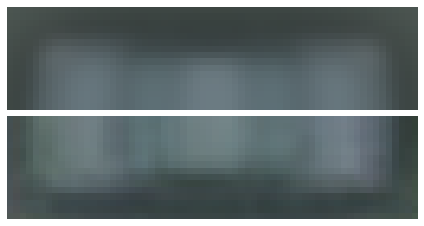

In [32]:
import os

from torchvision import transforms
from torchvision import utils
import torch as th

import matplotlib.pyplot as plt
from scripts import *

real_dir = "../potsdam_data/potsdam_cars_corrected"
artificial_dir1 = "experiments/ganspace/dcgan_experiments_version_2_epoch=974/nontruncated/nothing_disabled"
artificial_dir2 = "experiments/ganspace/dcgan_experiments_500_version_0_epoch=1294/nontruncated/nothing_disabled"

img_dim = (3, 32, 64)

transform = transforms.Compose([transforms.Resize(img_dim[1:]),
                                transforms.ToTensor(),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomVerticalFlip(p=0.5),
                                transforms.ColorJitter(
                                    hue=[-0.1, 0.1], contrast=[1, 1.25]),
                                transforms.Normalize([0.5], [0.5])])


potsdam = PostdamCarsDataModule(
    real_dir, img_size=img_dim[1:], batch_size=10000, transform=transform,  data_dir2=artificial_dir1)
potsdam.setup()
dataloader = potsdam.train_dataloader()
real, fake = next(iter(dataloader))
real_m = ((real.detach().clone().cpu().numpy() + 1) / 2).mean(axis=(0)).transpose(1,2,0)
fake_m = ((fake.detach().clone().cpu().numpy() + 1) / 2).mean(axis=(0)).transpose(1,2,0)
combined = np.ones((33, 64, 3))
combined[:16, :] = real_m[:16, :]
combined[17:, :] = fake_m[16:, :]

plt.imshow(combined)
plt.axis(False)
plt.tight_layout()
plt.savefig("figs/mean_1.png", dpi=300)


potsdam = PostdamCarsDataModule(
    real_dir, img_size=img_dim[1:], batch_size=10000, transform=transform,  data_dir2=artificial_dir2)
potsdam.setup()
dataloader = potsdam.train_dataloader()
real, fake = next(iter(dataloader))
real_m = ((real.detach().clone().cpu().numpy() + 1) / 2).mean(axis=(0)).transpose(1,2,0)
fake_m = ((fake.detach().clone().cpu().numpy() + 1) / 2).mean(axis=(0)).transpose(1,2,0)
combined = np.ones((33, 64, 3))
combined[:16, :] = real_m[:16, :]
combined[17:, :] = fake_m[16:, :]

plt.imshow(combined)
plt.axis(False)
plt.tight_layout()
plt.savefig("figs/mean_2.png", dpi=300)

## MUNIT EXAMPLES

/home/hca/Documents/Master/Thesis/Master-Thesis/.env/lib/python3.8/site-packages/torchvision/transforms/transforms.py:1200: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  warnings.warn(
/home/hca/Documents/Master/Thesis/Master-Thesis/.env/lib/python3.8/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


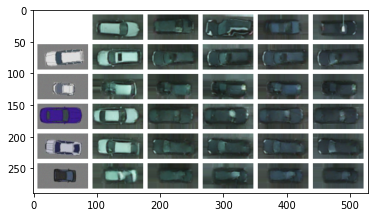

In [1]:
import os

from torchvision import transforms
from torchvision import utils
import torch as th

import matplotlib.pyplot as plt
from scripts import *

potsdam_dir = "../potsdam_data/potsdam_cars_corrected"
artificial_dir = "../potsdam_data/cem-v0/v2/training_tightcanvas_graybackground"
img_dim = (3, 40, 80)

# DATA AUG FOR
transform1 = transforms.Compose([transforms.ColorJitter(hue=[-0.1, 0.1]),
                                 DynamicPad(min_img_dim=(110, 60),
                                            padding_mode="edge"),
                                 transforms.RandomCrop(
                                     (55, 105), padding_mode="reflect"),
                                 transforms.Resize(img_dim[1:]),
                                 transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomVerticalFlip(p=0.5),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.5], [0.5])])

transform2 = transforms.Compose([transforms.ColorJitter(hue=[-0.1, 0.1]),
                                 DynamicPad(min_img_dim=(130, 70),
                                            padding_mode="constant", padding_value=125),
                                 transforms.RandomRotation(
                                     degrees=5, resample=PIL.Image.NEAREST, fill=125),
                                 transforms.RandomCrop(
                                     (60, 120), padding_mode="reflect"),
                                 transforms.Resize(img_dim[1:]),
                                 transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomVerticalFlip(p=0.5),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.5], [0.5]),
                                 AddNoise(alpha=0.07)])


potsdam = PostdamCarsDataModule(
    potsdam_dir, img_size=img_dim[1:], batch_size=5,
    data_dir2=artificial_dir, transform=transform1, transform2=transform2)
potsdam.setup()
dataloader = potsdam.train_dataloader()

# style and content vector
real, artificial = next(iter(dataloader))


# munit1
path = "experiments/munit_version_2_larger_image_corrected/lightning_logs/version_1/checkpoints/epoch=899.ckpt"
model = MUNIT.load_from_checkpoint(path)
model.eval()
model.cuda()

encoder1 = model.generator.encoder1
encoder2 = model.generator.encoder2
decoder1 = model.generator.decoder1
decoder2 = model.generator.decoder2
img_styles = real.to(model.device)
img_contents = artificial.to(model.device)

contents, _ = encoder1(img_contents)
_, styles = encoder2(img_styles)

# image styles will be the first row
grid = [th.ones(real.shape[1:], device="cpu")] + \
    [img_style.detach().cpu().clone()
     for img_style in img_styles]

for i, content in enumerate(contents):
    # for each content create n_random_styles
    row = th.cat(
        [th.unsqueeze(content, 0) for _ in range(len(img_styles))], dim=0)
    imgs = decoder2(row.to(model.device),
                    styles.to(model.device))

    # a row consists of content image and its style mixing
    grid.append(img_contents[i].detach().cpu().clone())
    grid += [img.detach().cpu().clone()
             for img in imgs]

# save everyting
grid = torchvision.utils.make_grid(
    grid, nrow=len(img_styles) + 1, pad_value=1, padding=7, normalize=True, range=(-1, 1)).numpy().transpose(1, 2, 0)

plt.imshow(grid)
plt.axis(False)
plt.tight_layout()
plt.savefig("figs/munit_22.png", dpi=600)

## GANSPACE EXAMPLES

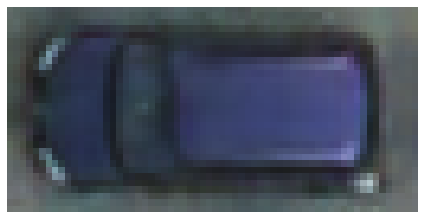

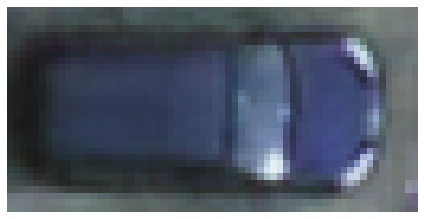

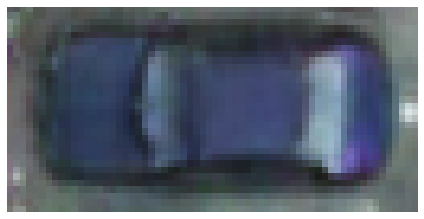

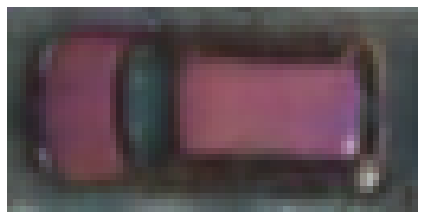

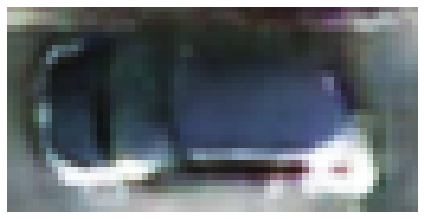

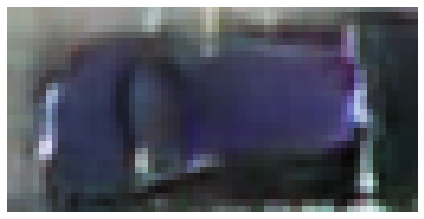

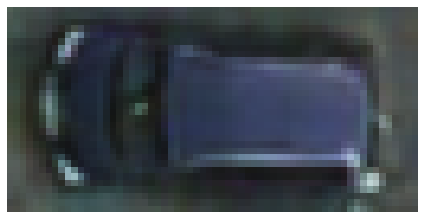

In [17]:
import os
import pickle

import torch as th 
import numpy as np
import matplotlib.pyplot as plt
import torchvision;

from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

from scripts import *

import matplotlib


# input
# model_checkpoint = best model pat
model_checkpoint = "experiments/dcgan_experiments/lightning_logs/version_2/checkpoints/epoch=974.ckpt"
save_path = "experiments/ganspace/dcgan_experiments_version_2_epoch=974"

model = GAN.load_from_checkpoint(model_checkpoint)
model.eval()

d = np.load(os.path.join(save_path, "pca_generator.npy"), allow_pickle=True).item()
comp = d["E"]
mean = d["mu"]
stds = d["stds"]

with th.no_grad():
    E = th.tensor(comp, device=model.device, dtype=th.float)
    mu = th.tensor(mean, device=model.device, dtype=th.float)
    gen = PCAGenerator(model.generator, E, mu)

    # z = th.tensor([np.random.normal(0, scale) for scale in stds], device=model.device)
    z[0] = 9
    z[2] = stds[2]*1
    z[7] = 2*stds[7]
    z[10] = 0
    z[25] = 0
    
    # change orientation
    z1 = z.clone()
    z1[0] = -11
    
    # change car type
    z2 = z.clone()
    z2[2] = -stds[2]*3
    
    # change color
    z3 = z.clone()
    z3[7] = -2*stds[7]
    
    
    # change lightining
    z4 = z.clone()
    z4[10] = 3*stds[10]*2
    
    # deformation
    z5 = z.clone()
    z5[17] = -3*stds[17]*5
    
    
    # zoom in
    z6 = z.clone()
    z6[13] = -3*stds[13]*2
    
    
    car = (th.squeeze(gen(z).detach().cpu()).numpy().transpose(1, 2, 0) + 1) / 2
    car1 = (th.squeeze(gen(z1).detach().cpu()).numpy().transpose(1, 2, 0) + 1) / 2
    car2 = (th.squeeze(gen(z2).detach().cpu()).numpy().transpose(1, 2, 0) + 1) / 2
    car3 = (th.squeeze(gen(z3).detach().cpu()).numpy().transpose(1, 2, 0) + 1) / 2
    car4 = (th.squeeze(gen(z4).detach().cpu()).numpy().transpose(1, 2, 0) + 1) / 2
    car5 = (th.squeeze(gen(z5).detach().cpu()).numpy().transpose(1, 2, 0) + 1) / 2
    car6 = (th.squeeze(gen(z6).detach().cpu()).numpy().transpose(1, 2, 0) + 1) / 2

import scipy.ndimage as nd
cars = [car, car1, car2, car3, car4, car5, car6]
for i, c in enumerate(cars):
    plt.figure()
    plt.imshow(c)
    plt.axis(False)
    plt.tight_layout()
    plt.savefig("figs/car_%d.png" % i, dpi=600)  
    

## AAAA

In [5]:
import os

from torchvision import transforms
from torchvision import utils
import torch as th

import matplotlib.pyplot as plt
from scripts import *

potsdam_dir = "../potsdam_data/potsdam_cars_corrected"
artificial_dir = "../potsdam_data/cem-v0/v2/training_tightcanvas_graybackground"
img_dim = (3, 40, 80)

# DATA AUG FOR
transform1 = transforms.Compose([transforms.ColorJitter(hue=[-0.1, 0.1]),
                                 DynamicPad(min_img_dim=(110, 60),
                                            padding_mode="edge"),
                                 transforms.RandomCrop(
                                     (55, 105), padding_mode="reflect"),
                                 transforms.Resize(img_dim[1:]),
                                 transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomVerticalFlip(p=0.5),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.5], [0.5])])

transform2 = transforms.Compose([transforms.ColorJitter(hue=[-0.1, 0.1]),
                                 DynamicPad(min_img_dim=(130, 70),
                                            padding_mode="constant", padding_value=125),
                                 transforms.RandomRotation(
                                     degrees=5, resample=PIL.Image.NEAREST, fill=125),
                                 transforms.RandomCrop(
                                     (60, 120), padding_mode="reflect"),
                                 transforms.Resize(img_dim[1:]),
                                 transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomVerticalFlip(p=0.5),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.5], [0.5]),
                                 AddNoise(alpha=0.07)])


potsdam = PostdamCarsDataModule(
    potsdam_dir, img_size=img_dim[1:], batch_size=9,
    data_dir2=artificial_dir, transform=transform1, transform2=transform2)
potsdam.setup()
dataloader = potsdam.train_dataloader()

# style and content vector
real, artificial = next(iter(dataloader))


# munit1
path = "experiments/munit_version_2_larger_image_corrected/lightning_logs/version_1/checkpoints/epoch=899.ckpt"
model = MUNIT.load_from_checkpoint(path)
model.eval()
model.cuda()

encoder1 = model.generator.encoder1
encoder2 = model.generator.encoder2
decoder1 = model.generator.decoder1
decoder2 = model.generator.decoder2
img_styles = real.to(model.device)
img_contents = artificial.to(model.device)

contents, _ = encoder1(img_contents[:2])
_, styles = encoder2(img_styles)

# image styles will be the first row
grid = [th.ones(real.shape[1:], device="cpu")] + \
    [img_style.detach().cpu().clone()
     for img_style in img_styles]

for i, content in enumerate(contents):
    # for each content create n_random_styles
    row = th.cat(
        [th.unsqueeze(content, 0) for _ in range(len(img_styles))], dim=0)
    imgs = decoder2(row.to(model.device),
                    styles.to(model.device))

    # a row consists of content image and its style mixing
    grid.append(img_contents[i].detach().cpu().clone())
    grid += [img.detach().cpu().clone()
             for img in imgs]

# save everyting
grid = torchvision.utils.make_grid(
    grid, nrow=len(img_styles) + 1, pad_value=1, normalize=True, range=(-1, 1))
torchvision.utils.save_image(grid, "figs/style_mixing_munit_.png")

